In [2]:
import sympy as sp
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments

In [3]:
# Step 1: Generate Functions and Taylor Expansions
def generate_dataset(n_samples=1000):
    x = sp.Symbol('x')
    functions = [sp.sin(x), sp.cos(x), sp.exp(x), sp.log(1+x), x**2, x**3]
    dataset = []
    for _ in range(n_samples):
        f = np.random.choice(functions)  # Randomly select a function
        taylor_expansion = sp.series(f, x, 0, 5).removeO()
        dataset.append((str(f), str(taylor_expansion)))
    return dataset

In [4]:
dataset = generate_dataset()

In [5]:
# Step 2: Tokenization
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
def tokenize_function(equations):
    return tokenizer(equations, padding="max_length", truncation=True, max_length=128, return_tensors="pt")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [6]:
X, Y = zip(*dataset)
X_tokens = tokenize_function(list(X))
Y_tokens = tokenize_function(list(Y))

In [44]:
# Step 3: Dataset Preparation
class EquationDataset(torch.utils.data.Dataset):
    def __init__(self, inputs, outputs):
        self.inputs = inputs["input_ids"].long()
        self.outputs = outputs["input_ids"].long()

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return {"input_ids": self.inputs[idx], "labels": self.outputs[idx]}

dataset = EquationDataset(X_tokens, Y_tokens)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [45]:
# Step 4: Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)


    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # LSTM expects (batch_size, seq_length, input_size)
        return self.fc(lstm_out[:, -1, :])  # Take the last LSTM output

lstm_model = LSTMModel(1, 256, 128) # Adjust input_size to 1
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

In [46]:
def train_lstm(model, dataloader, epochs=10):
    model.train()
    for epoch in range(epochs):
        for batch in dataloader:
            inputs = batch["input_ids"].float()  # Shape: (batch_size, seq_length)
            labels = batch["labels"].float()

            print(f"Input shape before LSTM: {inputs.shape}")
            # The input to the LSTM should be 3D: (batch_size, seq_length, input_size)
            # We assume input_size is 1 for now, you may need to adjust this.
            # inputs = inputs.unsqueeze(-1)  # This line is no longer needed

            optimizer.zero_grad()
            # Pass the input to the model
            outputs = model(inputs)
            # Reshape the outputs and labels for the loss function
            # outputs will now be (batch_size, seq_length, output_size)
            # We need to reshape it to (batch_size * seq_length, output_size) for MSELoss
            outputs = outputs.reshape(-1, outputs.shape[-1]) # -1 infers the batch_size * seq_length
            labels = labels.reshape(-1, labels.shape[-1])    # Reshape labels similarly

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}, Loss: {loss.item()}")

train_lstm(lstm_model, train_loader)



Input shape before LSTM: torch.Size([16, 128, 1])
Input shape before LSTM: torch.Size([16, 128, 1])
Input shape before LSTM: torch.Size([16, 128, 1])
Input shape before LSTM: torch.Size([16, 128, 1])
Input shape before LSTM: torch.Size([16, 128, 1])
Input shape before LSTM: torch.Size([16, 128, 1])
Input shape before LSTM: torch.Size([16, 128, 1])
Input shape before LSTM: torch.Size([16, 128, 1])
Input shape before LSTM: torch.Size([16, 128, 1])
Input shape before LSTM: torch.Size([16, 128, 1])
Input shape before LSTM: torch.Size([16, 128, 1])
Input shape before LSTM: torch.Size([16, 128, 1])
Input shape before LSTM: torch.Size([16, 128, 1])
Input shape before LSTM: torch.Size([16, 128, 1])
Input shape before LSTM: torch.Size([16, 128, 1])
Input shape before LSTM: torch.Size([16, 128, 1])
Input shape before LSTM: torch.Size([16, 128, 1])
Input shape before LSTM: torch.Size([16, 128, 1])
Input shape before LSTM: torch.Size([16, 128, 1])
Input shape before LSTM: torch.Size([16, 128, 1])


In [47]:
# Step 5: Define Transformer Model
transformer_model = GPT2LMHeadModel.from_pretrained("gpt2")
transformer_model.resize_token_embeddings(len(tokenizer))


training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
)

trainer = Trainer(
    model=transformer_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.train()


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch,Training Loss,Validation Loss
1,0.366800,0.069421
2,0.092200,0.047993
3,0.070600,0.031666


TrainOutput(global_step=300, training_loss=0.1765560515721639, metrics={'train_runtime': 5601.8121, 'train_samples_per_second': 0.428, 'train_steps_per_second': 0.054, 'total_flos': 156775219200000.0, 'train_loss': 0.1765560515721639, 'epoch': 3.0})

In [49]:
# Step 6: Evaluate Transformer Model
def generate_taylor_expansion(prompt):
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    output = transformer_model.generate(input_ids, max_length=50)
    return tokenizer.decode(output[0], skip_special_tokens=True)

test_prompt = "sin(x)"
predicted_expansion = generate_taylor_expansion(test_prompt)
print("Predicted Taylor Expansion:", predicted_expansion)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Predicted Taylor Expansion: sin(x)/6/cos6/6 +/6 +/6 +/6 +/6 +/6 +/6 +/6 +/6 +/6 +/6 +/6 +/6 +/6


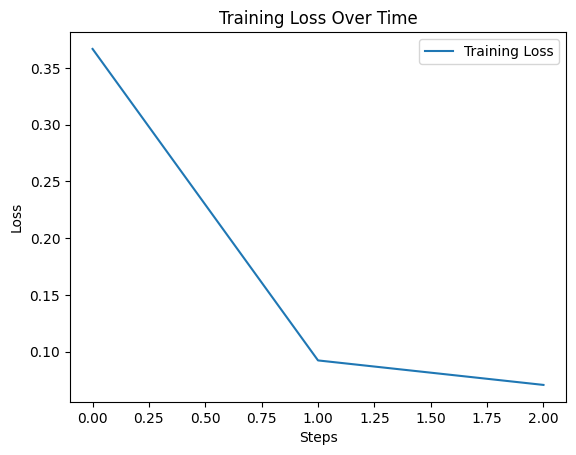

In [50]:
# Step 7: Visualization
train_loss = trainer.state.log_history
losses = [entry['loss'] for entry in train_loss if 'loss' in entry]
plt.plot(losses, label='Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()